## Fit distribution to each protein
- Previous I used the difference in activity as the loss funciton
- What if we just fit a normal distribution to each protein/experiment, and try to predict the mean (optimum) and standard deviation (range) directly?

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
os.chdir("../../../")
os.getcwd()

'/lustre/eaglefs/projects/robustmicrob/jlaw/projects/prot_stability_engineering'

In [3]:
inputs_dir = Path("inputs/brenda")

In [4]:
# This file has all the ph range data + optimum ph data
data_file = inputs_dir / "20230926_ph_data_merged.csv"
data_act_merged = pd.read_csv(data_file)
data_act_merged = data_act_merged.dropna(subset=["ph", "activity"], how="any")
print(len(data_act_merged), 
      data_act_merged.exp_index.nunique(), 
      data_act_merged.uniprot_id.nunique())
data_act_merged.head(2)

25618 5632 13055


,exp_index,ph,activity,note,ph_range_comment,uniprot_id,reaction_type,enzyme_type,enzyme_type_sub,acceptor,...,comments,organism,ref,ph_range_ref_match,cofactor,substrate,enzyme_type_sub,max_min_diff,ph_dependence,min_max_diff
0,1.0,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46,reduction,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,7.5,0.6,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46,reduction,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# for some reason there's two enzyme_type_sub columns. combine them here
data_act_merged.loc[data_act_merged["enzyme_type_sub"].isnull(), "enzyme_type_sub"] = data_act_merged["enzyme_type_sub "]
data_act_merged.drop(columns=["enzyme_type_sub "], inplace=True)
data_act_merged.head(2)

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,reaction_type,enzyme_type,enzyme_type_sub,acceptor,...,name,comments,organism,ref,ph_range_ref_match,cofactor,substrate,max_min_diff,ph_dependence,min_max_diff
0,1.0,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46,reduction,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,7.5,0.6,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46,reduction,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# change 0% activity to 1-2% activity to get better fits
data_act_merged.loc[data_act_merged.activity == 0, "activity"] = 0.03

In [7]:
(data_act_merged.uniprot_id.value_counts() > 1).sum()

4536

In [8]:
from scipy.stats import norm
from scipy.optimize import curve_fit

# define the gaussian function for curve fitting
# def gaus(x,x_mean,sigma,c=100):
def gaus(x,x_mean,sigma):
    # fix c at 1 which would be the maximum activity
    c = 1
    return c*np.exp(-(x-x_mean)**2/(2*sigma**2))

In [9]:
def get_gaus_fit(data, C_init=100, mean_init=7.5, std_init=1):
    parameters, covariance = curve_fit(gaus, 
                                       data.ph.values, data.activity.values, 
                                       p0=[data.ph.values.mean(), 
                                           min(data.ph.std(), 4)],
                                       # bounds=([95, 0, 0], [105, 12, 5])
                                       bounds=([0,0], [13,4])
                                      )
    return pd.Series(parameters)

In [10]:
pd.options.mode.chained_assignment = None

In [11]:
# for each protein and experiment index with > 1 activity point, fit a distribution 
# then if there are multiple experiment indexes (e.g., multiple substrates) 
# take the mean of those distributions for now
data_multi = []
# if there's only one activity point, keep only the optimum value (i.e., drop points of activity < 1)
data_single = []
# sometimes there are multiple experiments for a protein where the ph optimum could have been from a different experiment.
# Keep track of those separately
data_single_2 = []
skipped = 0
for prot_exp, df_orig in data_act_merged.groupby(["uniprot_id", "reaction_type"], dropna=False):
    if len(df_orig) == 1:
        if df_orig.activity.values[0] >= 0.95:
            data_single += [list(prot_exp) + [df_orig.ph.values[0], np.nan, 1]]
        else:
            skipped += 1
        continue
    exp_fits = []
    for exp_idx, df in df_orig.groupby("exp_index", dropna=False):
        if len(df) == 1:
            if df.activity.values[0] >= 0.95:
                data_single_2 += [list(prot_exp) + [df.ph.values[0], np.nan, 1]]
            else:
                skipped += 1
            continue
        # if there's multiple optimum values, those are throwing off the curve fit
        df_opt = df[df.activity > 0.98]
        if len(df_opt) > 1:
            df_opt["ph"] = df_opt['ph'].mean()
            df_opt["activity"] = 1
            df = pd.concat([df[df.activity <= 0.98], df_opt.head(1)])

        if len(df) == 1:
            exp_fits += [[df.ph.values[0], np.nan]]
        else:
            try:
                gaus_mean, gaus_std = get_gaus_fit(df)
            except ValueError:
                print(df)
                raise
            exp_fits += [[gaus_mean, gaus_std]]
    if len(exp_fits) == 0:
        continue
    fit_mean = np.mean([m for m, s in exp_fits])
    fit_std = np.mean([s for m, s in exp_fits])
    data_multi += [list(prot_exp) + [fit_mean, fit_std, len(df_orig)]]
    
data_multi = pd.DataFrame(data_multi, columns=["uniprot_id", "reaction_type", "fit_mean", "fit_std", "num_act"])
data_single = pd.DataFrame(data_single, columns=["uniprot_id", "reaction_type", "fit_mean", "fit_std", "num_act"])
data_single_2 = pd.DataFrame(data_single_2, columns=["uniprot_id", "reaction_type", "fit_mean", "fit_std", "num_act"])
print(f"{len(data_single) = }, {len(data_single_2) = }, {len(data_multi) = }, {skipped = }")
print(data_multi.head(2))

/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/scipy/optimize/_minpack_p

len(data_single) = 9055, len(data_single_2) = 3145, len(data_multi) = 3089, skipped = 76
   uniprot_id reaction_type  fit_mean   fit_std  num_act
0  A0A023MIF8           NaN  4.600000       NaN        3
1  A0A024CDT8           NaN  6.754716  1.486879        3


/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/jlaw/.conda/envs/tm/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [18]:
data_multi

,uniprot_id,reaction_type,fit_mean,fit_std,num_act
0,A0A023MIF8,NaN,4.600000,NaN,3
1,A0A024CDT8,NaN,6.754716,1.486879,3
2,A0A031HCH9,NaN,7.620283,2.098399,7
3,A0A059ZV61,NaN,6.500000,0.738700,3
4,A0A060TAG5,NaN,6.347788,1.123345,3
...,...,...,...,...,...
3084,WP_028494267,NaN,7.000000,NaN,2
3085,WP_028992696,NaN,5.729900,0.843928,6
3086,WP_094046414.1,NaN,6.827814,1.146121,3
3087,X4QKX0,NaN,5.251441,1.236855,3


<AxesSubplot: ylabel='Frequency'>

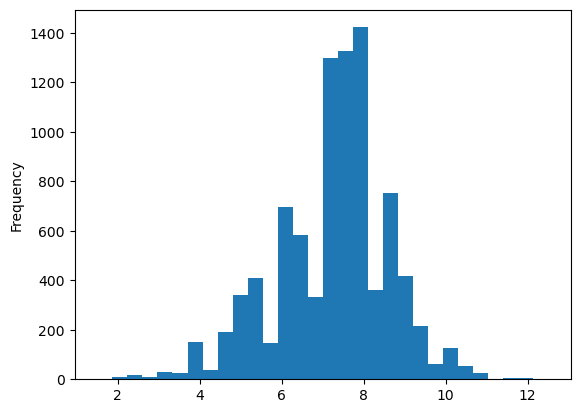

In [110]:
data_single.fit_mean.plot.hist(bins=30)

<AxesSubplot: ylabel='Frequency'>

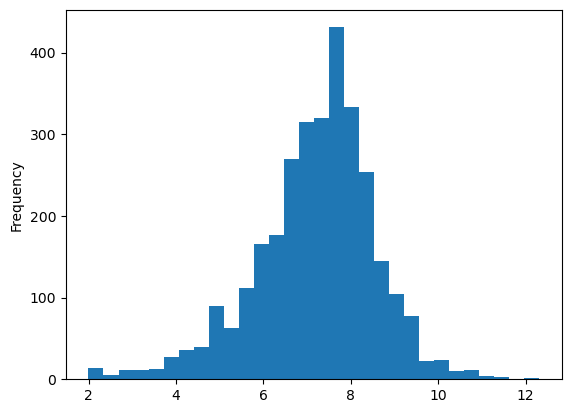

In [19]:
data_multi.fit_mean.plot.hist(bins=30)

<AxesSubplot: ylabel='Frequency'>

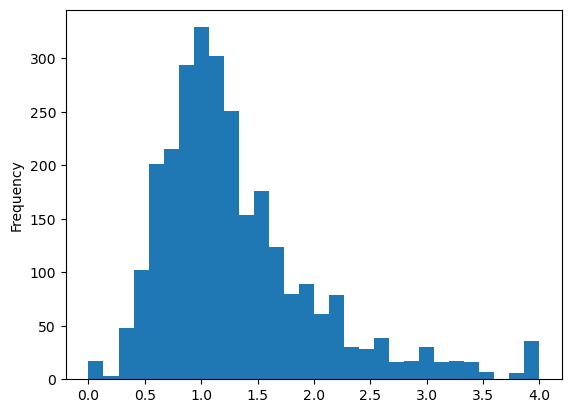

In [20]:
data_multi.fit_std.plot.hist(bins=30)

In [15]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [14]:
def plot_indv_prot_curves(df_fit, df_act, nrows=8, ncols=4):
    # get the predicted activity over all ph values
    all_ph_vals = np.arange(1, 13.5, 0.1)

    f, axes = plt.subplots(ncols=ncols, nrows=nrows, 
                           figsize=(ncols*2,nrows*2), 
                           sharey=True, sharex=False)
    axes_list = [ax for ax_row in axes for ax in ax_row]
    # cols = ["uniprot_id", "enzyme_type", "enzyme_type_sub", "acceptor"]
    i = -1
    for (u_id, df_u) in tqdm(df_fit.dropna(subset="fit_std").groupby("uniprot_id")):
        i += 1
        df_act_u = df_act[df_act.uniprot_id == u_id]
        df_pred_act_u = []
        for (r_type, df2) in df_u.groupby('reaction_type', dropna=False):
            pred_act = gaus(all_ph_vals, df2.fit_mean.values[0], df2.fit_std.values[0])
            # limit the predicted activity to min_ph -1 and max_ph +1
            df_pred_act_u_cat = pd.DataFrame({'ph': all_ph_vals, 'activity': pred_act})
            df_pred_act_u_cat['reaction_type'] = r_type
            ph_min = min(df_act_u.ph.min() - 1, 5.5)
            ph_max = max(df_act_u.ph.max() + 1, 8.5)
            df_pred_act_u_cat = df_pred_act_u_cat[(df_pred_act_u_cat.ph >= ph_min) & 
                                                  (df_pred_act_u_cat.ph <= ph_max)]
            df_pred_act_u += [df_pred_act_u_cat]
            # print(e_type, df_pred_act_u_cat[['ph', 'activity']].max())
        df_pred_act_u = pd.concat(df_pred_act_u)

        if i >= len(axes_list):
            break
        ax = axes_list[i]
        ax.set_title(u_id, fontsize=6)
        if "reduction" in df_act_u.reaction_type.unique() and \
           "oxidation" in df_act_u.reaction_type.unique():
            hue = "reaction_type"
            hue_order = ['reduction', 'oxidation']
            palette = "deep"
        else:
            hue = None
            hue_order = None
            palette = None
        sns.lineplot(x='ph', y='activity', data=df_pred_act_u, ax=ax,
                     hue=hue, hue_order=hue_order, palette=palette, 
                     size=1, 
                     legend=None)
        sns.scatterplot(x='ph', y='activity', data=df_act_u, ax=ax,
                        hue=hue, hue_order=hue_order, palette=palette, 
                        alpha=0.8,
                        legend=None
                       )
        ax.set_ylabel("")
        ax.set_xlabel("")
        # hide ax labels
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        # hide ax ticks
        ax.set_xticks([])
        ax.set_yticks([])

        # add a vertical bar at ph=6--8
        ax.axvspan(6, 8, alpha=0.1, color='purple')
        # ax.set_xlabel
        # L = ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

    # plt.tight_layout()
    plt.savefig("indv_prot_curves.pdf")
    plt.show()
    plt.close()

In [16]:
data_multi[data_multi.fit_std < 0.2]

,uniprot_id,reaction_type,fit_mean,fit_std,num_act
420,A5HLX5,oxidation,7.000000,1.000000e-10,2
823,E3Q9X3,oxidation,7.000000,1.000000e-10,4
1452,P07511,NaN,6.000000,1.000000e-10,2
1576,P0ABJ9,NaN,7.000000,1.000000e-10,2
1577,P0ABK2,NaN,7.000000,1.000000e-10,2
1746,P14519,NaN,6.000000,1.000000e-10,2
1813,P17977,NaN,8.400000,1.000000e-10,2
2303,P56100,NaN,7.000000,1.000000e-10,2
2338,P63235,NaN,6.184733,1.190481e-01,2
2529,P9WKL0,oxidation,10.250000,1.000000e-10,4


### Check the fits to make sure they're good
- Remove bad data, proteins with multiple matches
- Fix bad fits

24


  0%|          | 0/21 [00:00<?, ?it/s]

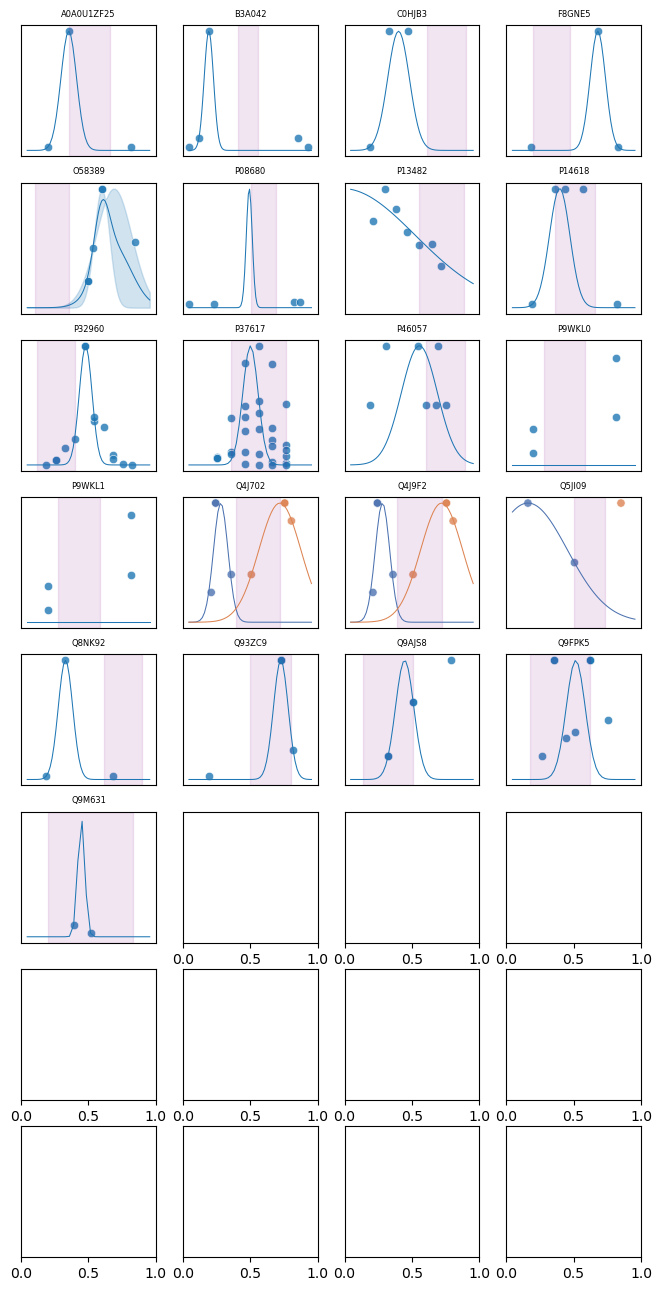

In [74]:
df_subset = data_multi[(data_multi.fit_std < 1.0) & 
                       (data_multi.fit_std >= 0.5)]
# df_subset = data_multi.copy()
# df_subset = df_subset[df_subset.uniprot_id.isin(bad_fits)]
print(len(df_subset))
plot_indv_prot_curves(df_subset.iloc[0:],
                      data_act_merged,
                      nrows=8, ncols=4)

In [44]:
data_multi[data_multi.uniprot_id.isin(["Q8KG69"])]

,uniprot_id,reaction_type,fit_mean,fit_std,num_act
3578,Q8KG69,NaN,7.166714,2.36935,5


In [48]:
data_act_merged[data_act_merged.uniprot_id.isin(["Q8KG69"])]

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,reaction_type,enzyme_type,enzyme_type_sub,acceptor,...,comments,organism,ref,ph_range_ref_match,cofactor,substrate,enzyme_type_sub,max_min_diff,ph_dependence,min_max_diff
4699,3123.0,7.5,0.4,more than 30-,more than 30-40% of maximum activity,Q8KG69,NaN,Hydrolases,acid anhydrides,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4700,3123.0,6.5,1.0,-,NaN,Q8KG69,NaN,Hydrolases,acid anhydrides,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4701,3123.0,5.5,0.4,more than 30-,more than 30-40% of maximum activity,Q8KG69,NaN,Hydrolases,acid anhydrides,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4704,3125.0,6.5,1.0,-,NaN,Q8KG69,NaN,Hydrolases,acid anhydrides,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4705,3125.0,10.0,0.9,NaN,about 90% of maximum activity,Q8KG69,NaN,Hydrolases,acid anhydrides,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Many of these have only 2 activity values, 
# but they're at the same pH, resulting in a very small std dev fit
bad_data = ["A5HLX5",
            "E3Q9X3",
            "P07511",
            "P0ABJ9",
            "P0ABK2",
            "P14519",
            "Q02196",
            "Q84H88",
            "Q9C2Y6",
            "P17977", 
            "P56100", 
            "Q88V19", 
            "Q9AQF3",
           ]

In [22]:
bad_fits = ["P9WKL0",
            "P9WKL1",
            "Q5JI09",
            "Q9M631",
            "B3A042", 
            "A0A0U1ZF25", 
            "C0HJB3", 
            "F8GNE5",
            "P08680",
            "P32960",
            "P37617",
            "Q4J702",
            "Q4J9F2",
            "Q8NK92",
            "Q93ZC9",
            "Q9AJS8",
            "Q9FPK5",
            "P14618",
            "P46057",
            "P08680",
            "P13482",
           ]

In [23]:
multi_reactions = ["P13708",
                   "Q7QBF7",
                   "Q7QF91",
                   "P46057",
                   "Q9FPK5",
                  ]

24


  0%|          | 0/21 [00:00<?, ?it/s]

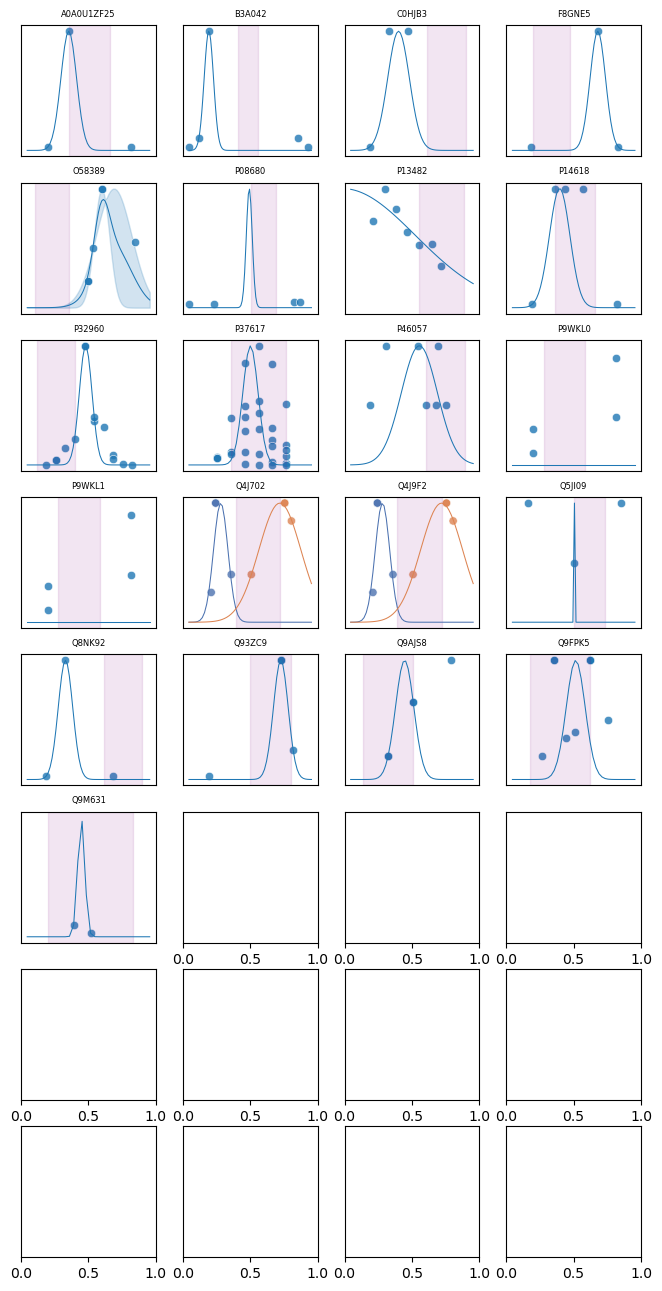

In [54]:
df_subset = data_multi.copy()
df_subset = df_subset[df_subset.uniprot_id.isin(bad_fits)]
df_subset = df_subset.sort_values("uniprot_id")
print(len(df_subset))
plot_indv_prot_curves(df_subset.iloc[0:],
                      data_act_merged,
                      nrows=8, ncols=4)

In [56]:
for u_id in sorted(bad_fits):
    print(data_multi[data_multi.uniprot_id == u_id])
    

     uniprot_id reaction_type  fit_mean   fit_std  num_act
126  A0A0U1ZF25     reduction  6.000244  0.377703        3
    uniprot_id reaction_type  fit_mean  fit_std  num_act
561     B3A042           NaN  3.014615  0.47294        5
    uniprot_id reaction_type  fit_mean   fit_std  num_act
633     C0HJB3           NaN  4.500653  0.566663        3
    uniprot_id reaction_type  fit_mean   fit_std  num_act
889     F8GNE5     oxidation  9.499709  0.415482        3
     uniprot_id reaction_type   fit_mean   fit_std  num_act
1252     O58389     oxidation   9.999413  0.459383        2
1253     O58389           NaN  10.732529  1.071790        4
     uniprot_id reaction_type  fit_mean   fit_std  num_act
1490     P08680           NaN     5.875  0.239873        4
     uniprot_id reaction_type  fit_mean   fit_std  num_act
1490     P08680           NaN     5.875  0.239873        4
     uniprot_id reaction_type  fit_mean   fit_std  num_act
1718     P13482           NaN  2.627676  3.225582        7
  

In [24]:
corrections = [["A0A0U1ZF25", 6.5, 1],
                ["B3A042", 5.5, 2],
                ["C0HJB3", 5, 1],
                ["F8GNE5", 8.5, 1],
                ["P08680", 5.875, 1.5],
                ["P13482", 5, 1],
                ["P14618", 7, 0.8],             
                ["P32960", 8.5, 0.5],
                ["P37617", 7, 0.75],
                ["P9WKL0", 8, 1.4],
                ["P9WKL1", 8, 1.4],
                ["Q8NK92", 4.6, 0.5],
                ["Q93ZC9", 7, 0.9],
                ["Q9AJS8", 9.5, 1.5],
                ["Q9M631", 5.5, 0.5],
           ]

In [25]:
df_corr = pd.DataFrame(corrections, columns=["uniprot_id", "fit_mean", "fit_std"])
df_corr = df_corr.set_index("uniprot_id")
df_corr["reaction_type"] = data_multi[data_multi.uniprot_id.isin(df_corr.index)].set_index("uniprot_id")["reaction_type"]
df_corr["num_act"] = data_multi[data_multi.uniprot_id.isin(df_corr.index)].set_index("uniprot_id")["num_act"]
df_corr.head(2)

,fit_mean,fit_std,reaction_type,num_act
uniprot_id,,,,
A0A0U1ZF25,6.5,1.0,reduction,3
B3A042,5.5,2.0,NaN,5


In [75]:
data_multi.head(2)

,uniprot_id,reaction_type,fit_mean,fit_std,num_act
0,A0A023MIF8,NaN,4.600000,NaN,3
1,A0A024CDT8,NaN,6.754716,1.486879,3


In [26]:
data_multi_fixes = data_multi.copy()
print(len(data_multi_fixes))
data_multi_fixes = data_multi_fixes[~data_multi_fixes.uniprot_id.isin(df_corr.index)]
data_multi_fixes = pd.concat([data_multi_fixes, df_corr.reset_index()])
print(len(data_multi_fixes))
data_multi_fixes = data_multi_fixes[~data_multi_fixes.uniprot_id.isin(bad_data + multi_reactions)]
print(len(data_multi_fixes))

3089
3089
3071


15


  0%|          | 0/15 [00:00<?, ?it/s]

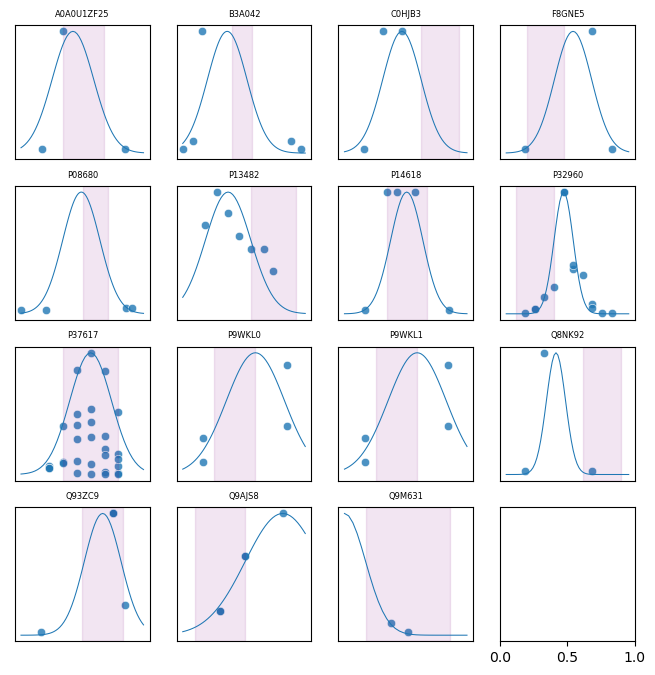

In [27]:
df_subset = data_multi_fixes.copy()
df_subset = df_subset[df_subset.uniprot_id.isin(df_corr.index)]
df_subset = df_subset.sort_values("uniprot_id")
print(len(df_subset))
plot_indv_prot_curves(df_subset.iloc[0:],
                      data_act_merged,
                      nrows=4, ncols=4)

Text(0.5, 0, 'pH opt')

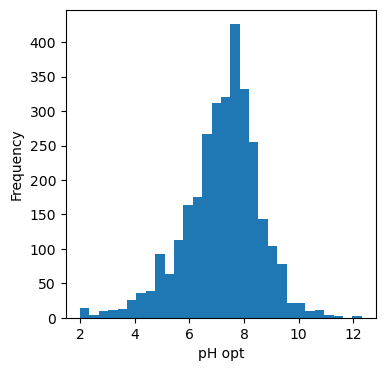

In [29]:
f, ax = plt.subplots(figsize=(4,4))
data_multi_fixes.fit_mean.plot.hist(bins=30)
ax.set_xlabel("pH opt")

<AxesSubplot: ylabel='Frequency'>

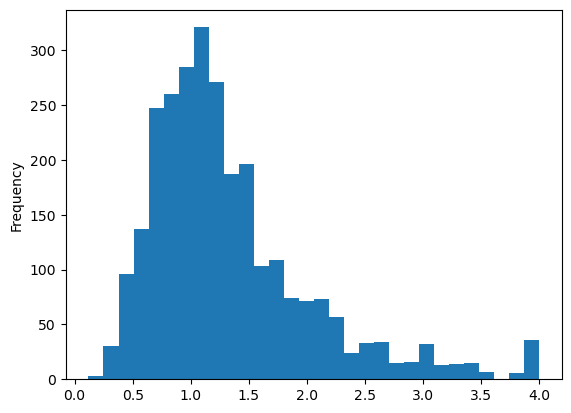

In [30]:
data_multi_fixes.fit_std.plot.hist(bins=30)

In [31]:
data_multi_fixes.tail()

,uniprot_id,reaction_type,fit_mean,fit_std,num_act
10,P9WKL1,oxidation,8.0,1.4,4
11,Q8NK92,NaN,4.6,0.5,3
12,Q93ZC9,NaN,7.0,0.9,5
13,Q9AJS8,NaN,9.5,1.5,5
14,Q9M631,reduction,5.5,0.5,2


### Now combine with the ph opt data (that has no standard dev.)

In [32]:
data_fits = pd.concat([data_single, data_single_2, data_multi_fixes])
print(len(data_fits), data_fits.uniprot_id.nunique())
data_fits.head(2)

15271 12997


,uniprot_id,reaction_type,fit_mean,fit_std,num_act
0,05650,NaN,8.4,NaN,1
1,5650,NaN,8.4,NaN,1


Need to fix the rows with multiple ph optimums

In [33]:
# for each uniprot ID and redox_type combo, take the average pH as the optimum
data_opt_mean = []
for cols, df in data_fits[data_fits.uniprot_id.isin(data_single_2.uniprot_id)].groupby(["uniprot_id", "reaction_type"], dropna=False):
    # print(cols, df)
    if len(df) == 1:
        data_opt_mean += [df]
        continue
    ph_min, ph_max = df.fit_mean.min(), df.fit_mean.max()
    df["max_min_diff"] = ph_max - ph_min
    # remove proteins with a ph opt spread > 4 ph
    if abs(ph_max - ph_min) > 4:
        # print(df)
        continue
    ph_mean = df.fit_mean.mean()
    df["fit_mean"] = ph_mean
    df["num_act"] = df["num_act"].sum()
    # if there's a row with the std, then use that
    if len(df.dropna(subset="fit_std")) > 0:
        data_opt_mean += [df.dropna(subset="fit_std").head(1)]
    else:
        data_opt_mean += [df.head(1)]

data_opt_mean = pd.concat(data_opt_mean)
print(len(data_opt_mean))
data_opt_mean.head(2)

1860


,uniprot_id,reaction_type,fit_mean,fit_std,num_act,max_min_diff
0,A0A059WLZ7,NaN,7.0,NaN,2,0.0
3,A0A059ZV61,NaN,6.0,0.7387,4,1.0


In [135]:
data_opt_mean

,uniprot_id,reaction_type,fit_mean,fit_std,num_act,max_min_diff
0,A0A059WLZ7,NaN,7.000000,NaN,2,0.000000
3,A0A059ZV61,NaN,6.000000,0.738700,4,1.000000
3,A0A060S684,NaN,7.500000,NaN,2,0.000000
5,A0A067XR63,NaN,5.625000,NaN,4,0.250000
6,A0A067XRK9,NaN,5.875000,NaN,4,0.250000
...,...,...,...,...,...,...
3136,W8E7D1,NaN,8.750000,NaN,2,0.000000
3138,W8JNL4,NaN,6.500000,NaN,2,0.000000
3081,W8QRE4,NaN,5.500106,0.642623,6,0.000211
3141,X2JCV5,NaN,7.725000,NaN,2,0.150000


In [131]:
data_opt_mean

,uniprot_id,reaction_type,fit_mean,fit_std,num_act,max_min_diff
0,A0A059WLZ7,NaN,7.000000,NaN,1,0.000000
3,A0A059ZV61,NaN,6.000000,0.738700,3,1.000000
3,A0A060S684,NaN,7.500000,NaN,1,0.000000
5,A0A067XR63,NaN,5.625000,NaN,1,0.250000
6,A0A067XRK9,NaN,5.875000,NaN,1,0.250000
...,...,...,...,...,...,...
3136,W8E7D1,NaN,8.750000,NaN,1,0.000000
3138,W8JNL4,NaN,6.500000,NaN,1,0.000000
3081,W8QRE4,NaN,5.500106,0.642623,5,0.000211
3141,X2JCV5,NaN,7.725000,NaN,1,0.150000


In [34]:
data_fits[data_fits.uniprot_id.isin(data_opt_mean[data_opt_mean.max_min_diff > 2].uniprot_id)].sort_values("uniprot_id")

,uniprot_id,reaction_type,fit_mean,fit_std,num_act
13,A0A0A1H7N4,NaN,6.750000,NaN,1
14,A0A0A1H7N4,NaN,9.800000,NaN,1
16,A0A0A1HA03,NaN,6.750000,NaN,1
17,A0A0A1HA03,NaN,9.800000,NaN,1
222,B3A0S5,NaN,7.000000,NaN,1
470,B3A0S5,NaN,5.000000,1.251168,5
264,B8YG19,NaN,5.800000,NaN,1
265,B8YG19,NaN,8.200000,NaN,1
474,G2QCS4,NaN,5.000000,NaN,1
723,G2QCS4,NaN,7.250000,2.335635,3


<AxesSubplot: ylabel='Frequency'>

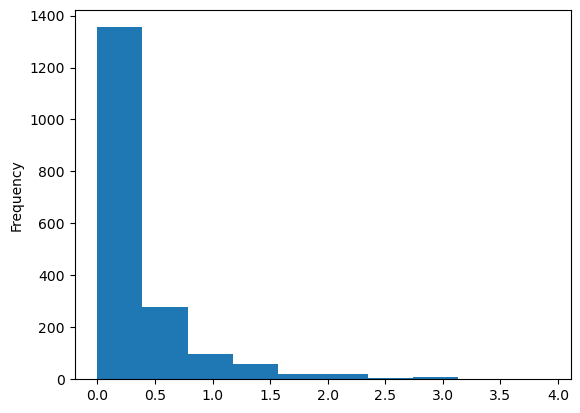

In [35]:
data_opt_mean.max_min_diff.plot.hist()

In [ ]:
data_act_merged[data_act_merged.uniprot_id.isin(["A0A059WLZ7"])]

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,reaction_type,enzyme_type,enzyme_type_sub,acceptor,...,comments,organism,ref,ph_range_ref_match,cofactor,substrate,enzyme_type_sub,max_min_diff,ph_dependence,min_max_diff
13798,NaN,7.0,1.0,NaN,NaN,A0A059WLZ7,NaN,Oxidoreductases,NaN,other,...,-,Rhizorhabdus wittichii,741685,NaN,NaN,NaN,"paired donors, with molecular oxygen",NaN,NaN,NaN
20686,3007.0,7.0,1.0,{ECO:0000269|PubMed:24928877};,NaN,A0A059WLZ7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Optimum pH is 7. {ECO:0000269|PubMed:24928877};,NaN


### Add the enzyme type to the data

In [36]:
# I forgot to get the enzyme type for the uniprot dataset, so combine that here
inputs_dir = "inputs/uniprot"
# load the pH range and opt values
data_file = Path(inputs_dir, "uniprotkb_cc_bpcp_2023_09_22.tsv.gz")
print(data_file)
data_u = pd.read_table(data_file)
data_u = data_u.rename(columns={"Entry": "uniprot_id", "Sequence": "sequence", "pH dependence": "ph_dependence", "EC number": "ec_num"})
print(len(data_u))
data_u.head(2)

inputs/uniprot/uniprotkb_cc_bpcp_2023_09_22.tsv.gz
11217


,uniprot_id,Reviewed,Protein names,Gene Names,Organism,Organism (ID),Length,ph_dependence,sequence,Kinetics,...,Temperature dependence,ec_num,Catalytic activity,Cofactor,Activity regulation,Binding site,Active site,Site,Pathway,Absorption
0,A0A023I7E1,reviewed,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",ENG1 LAM81A,Rhizomucor miehei,4839,796,BIOPHYSICOCHEMICAL PROPERTIES: pH dependence:...,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,NaN,...,BIOPHYSICOCHEMICAL PROPERTIES: Temperature de...,3.2.1.39,CATALYTIC ACTIVITY: Reaction=Hydrolysis of (1-...,NaN,ACTIVITY REGULATION: Tris binds the active sit...,"BINDING 504; /ligand=""(1,3-beta-D-glucosyl)n"";...","ACT_SITE 500; /evidence=""ECO:0000255|PROSITE-P...",NaN,NaN,NaN
1,A0A024SC78,reviewed,Cutinase (EC 3.1.1.74),M419DRAFT_76732,Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,1344414,248,BIOPHYSICOCHEMICAL PROPERTIES: pH dependence:...,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,NaN,...,NaN,3.1.1.74,CATALYTIC ACTIVITY: Reaction=cutin + H2O = cut...,NaN,ACTIVITY REGULATION: Weakly inhibited by n-und...,NaN,"ACT_SITE 164; /note=""Nucleophile""; /evidence=""...","SITE 90; /note=""Transition state stabilizer""; ...",NaN,NaN


In [37]:
data_u_ec = data_u[["uniprot_id", "ec_num"]].dropna()
print(len(data_u_ec), data_u_ec.ec_num.nunique())

9927 4049


In [38]:
def combine_ec_nums(ec_nums):
    if ';' in ec_nums:
        ec_nums = ec_nums.split('; ')
        first_three_ecs = set(['.'.join(ec.split('.')[:3]) for ec in ec_nums])
        if len(first_three_ecs) == 1:
            if '-' in list(first_three_ecs)[0]:
                return np.nan
            else:
                return ec_nums[1]
        else:
            return np.nan
    else:
        if '-' in '.'.join(ec_nums.split('.')[:3]):
            return np.nan
        return ec_nums

In [39]:
data_u_ec["ec_combined"] = data_u_ec.ec_num.apply(combine_ec_nums)
data_u_ec = data_u_ec.dropna(subset="ec_combined")
print(len(data_u_ec))
# data_u_ec.loc[data_u_ec.ec_num.apply(lambda x: ";" in x), "ec_num"] = data_u_ec[data_u_ec.ec_num.apply(lambda x: ";" in x)].apply(
    # lambda x: 

9186


In [40]:
from src.brenda_enzyme_types import add_enzyme_types
data_u_ec = add_enzyme_types(data_u_ec)
data_u_ec = data_u_ec.rename(columns={"enzyme_type_sub ": "enzyme_type_sub"})
data_u_ec.set_index("uniprot_id", inplace=True)
data_u_ec.head(2)

,ec_num,ec_combined,enzyme_type,enzyme_type_sub,acceptor
uniprot_id,,,,,
A0A023I7E1,3.2.1.39,3.2.1.39,Hydrolases,Glycosylases,NaN
A0A024SC78,3.1.1.74,3.1.1.74,Hydrolases,ester bonds,NaN


In [274]:
len(data_u_ec)

9186

In [41]:
data_act_merged2 = data_act_merged[(data_act_merged.enzyme_type.isna()) & 
                                   (data_act_merged.uniprot_id.isin(data_u_ec.index))]
data_act_merged2["enzyme_type"] = data_act_merged2.uniprot_id.apply(lambda x: data_u_ec.loc[x].enzyme_type)
data_act_merged2["enzyme_type_sub"] = data_act_merged2.uniprot_id.apply(lambda x: data_u_ec.loc[x].enzyme_type_sub)
data_act_merged2["acceptor"] = data_act_merged2.uniprot_id.apply(lambda x: data_u_ec.loc[x].acceptor)
data_act_merged2.head(2)

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,reaction_type,enzyme_type,enzyme_type_sub,acceptor,...,name,comments,organism,ref,ph_range_ref_match,cofactor,substrate,max_min_diff,ph_dependence,min_max_diff
9390,3.0,6.0,0.821962,ecoli_man,NaN,P21170,NaN,Lyases,Carbon-carbon,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9391,3.0,6.5,0.863941,ecoli_man,NaN,P21170,NaN,Lyases,Carbon-carbon,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
data_act_merged.loc[data_act_merged2.index, ["enzyme_type", "enzyme_type_sub", "acceptor"]] = data_act_merged2[["enzyme_type", "enzyme_type_sub", "acceptor"]]
data_act_merged.tail(2)

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,reaction_type,enzyme_type,enzyme_type_sub,acceptor,...,name,comments,organism,ref,ph_range_ref_match,cofactor,substrate,max_min_diff,ph_dependence,min_max_diff
25620,4368.0,5.5,1.0,NaN,NaN,B0K2C3,NaN,Transferases,Glycosyltransferases,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Optimum pH is 6.0 for phosphorolytic activity....,NaN
25621,4378.0,6.4,1.0,substrate dependent,NaN,B3EWI3,NaN,Oxidoreductases,diphenols and related substances as donors,oxygen,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Optimum pH is 5.2 with ABTS as substrate. Opti...,NaN


In [43]:
ez_types = data_act_merged[["uniprot_id", "enzyme_type", "enzyme_type_sub", "acceptor"]].dropna(subset="enzyme_type")
ez_types = ez_types[ez_types.uniprot_id.isin(data_fits2.uniprot_id)]
ez_types = ez_types.drop_duplicates()
print(len(ez_types), ez_types.uniprot_id.nunique())

12608 12513


In [44]:
counts = ez_types.uniprot_id.value_counts()

In [45]:
ez_types[ez_types.uniprot_id.isin(counts[counts > 1].index)].sort_values("uniprot_id")

,uniprot_id,enzyme_type,enzyme_type_sub,acceptor
15347,A0A067XR63,Transferases,Glycosyltransferases,NaN
17380,A0A067XR63,Hydrolases,Glycosylases,NaN
15348,A0A067XRK9,Transferases,Glycosyltransferases,NaN
17381,A0A067XRK9,Hydrolases,Glycosylases,NaN
18215,A0A077AY47,Hydrolases,ether bonds,NaN
...,...,...,...,...
14131,W8CR61,Oxidoreductases,aldehyde or oxo group of donors,iron-sulfur protein
16703,W8E7D1,Hydrolases,ester bonds,NaN
25103,W8E7D1,Hydrolases,acid anhydrides,NaN
15417,WP_028494267,Transferases,Glycosyltransferases,NaN


In [46]:
ez_types[ez_types.uniprot_id.isin(counts[counts > 1].index)].sort_values("uniprot_id").enzyme_type.value_counts()

Oxidoreductases    80
Lyases             36
Hydrolases         31
Transferases       26
Isomerases         14
Translocases        2
Name: enzyme_type, dtype: int64

In [47]:
# drop uniprot ids with multiple enzyme types for now
ez_types = ez_types[ez_types.uniprot_id.isin(counts[counts == 1].index)]
print(len(ez_types), ez_types.uniprot_id.nunique())

12419 12419


In [48]:
data_fits2 = data_fits[~data_fits.uniprot_id.isin(data_single_2.uniprot_id)]
data_fits2 = pd.concat([data_fits2, data_opt_mean])
print(len(data_fits2), data_fits2.uniprot_id.nunique())

13405 12994


In [49]:
ez_types.head(2)

,uniprot_id,enzyme_type,enzyme_type_sub,acceptor
0,B2KJ46,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+
3,Q4J702,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+


In [50]:
data_fits_ez_types = data_fits2.merge(ez_types, on="uniprot_id")
print(len(data_fits_ez_types))
data_fits2 = pd.concat([data_fits_ez_types, data_fits2[~data_fits2.uniprot_id.isin(ez_types.uniprot_id)]])
print(len(data_fits2))
data_fits2.head(2)

12811
13405


,uniprot_id,reaction_type,fit_mean,fit_std,num_act,max_min_diff,enzyme_type,enzyme_type_sub,acceptor
0,05650,NaN,8.4,NaN,1,NaN,Lyases,Carbon-carbon,NaN
1,5650,NaN,8.4,NaN,1,NaN,Oxidoreductases,aldehyde or oxo group of donors,iron-sulfur protein


In [51]:
data_fits2.enzyme_type.value_counts()

Hydrolases         4706
Oxidoreductases    3355
Transferases       2634
Lyases             1146
Isomerases          536
Ligases             343
Translocases         91
Name: enzyme_type, dtype: int64

In [52]:
print(len(data_fits2.enzyme_type.dropna()), len(data_fits2.enzyme_type_sub.dropna()), len(data_fits2.acceptor.dropna()))

12811 12811 3355


In [54]:
out_file = "inputs/ph_merged/20230927_ph_curves.csv"
data_fits2.to_csv(out_file, index=None)

In [12]:
out_file = "inputs/ph_merged/20230927_ph_curves.csv"
data_fits2 = pd.read_csv(out_file)
data_fits2.head(2)

,uniprot_id,reaction_type,fit_mean,fit_std,num_act,max_min_diff,enzyme_type,enzyme_type_sub,acceptor
0,05650,NaN,8.4,NaN,1,NaN,Lyases,Carbon-carbon,NaN
1,5650,NaN,8.4,NaN,1,NaN,Oxidoreductases,aldehyde or oxo group of donors,iron-sulfur protein


In [288]:
print(len(data_fits2), len(data_fits2.dropna(subset="fit_std")), len(data_fits2.dropna(subset="reaction_type")))

13411 2771 1108


In [287]:
data_fits2.enzyme_type_sub.value_counts().head(20)

Glycosylases                                       1433
CH-OH group of donors                               997
ester bonds                                         866
peptide bonds (peptidases)                          681
phosphorus-containing groups                        633
Glycosyltransferases                                553
carbon-nitrogen bonds, other than peptide bonds     427
Carbon-oxygen                                       417
Carbon-carbon                                       365
Acyltransferases                                    326
paired donors, with molecular oxygen                317
aldehyde or oxo group of donors                     274
one-carbon groups                                   255
CH-NH2 group of donors                              205
CH-CH group of donors                               189
alkyl or aryl groups, other than methyl groups      187
oxygenases                                          181
Intramolecular oxidoreductases                  

Text(0.5, 0, 'pH opt')

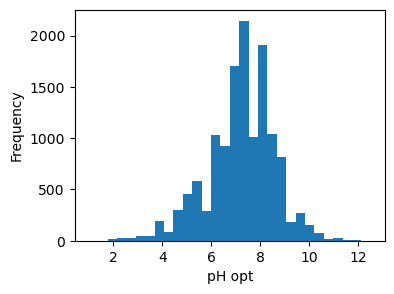

In [55]:
f, ax = plt.subplots(figsize=(4,3))
data_fits2.fit_mean.plot.hist(bins=30)
ax.set_xlabel("pH opt")

Text(0.5, 0, 'pH std')

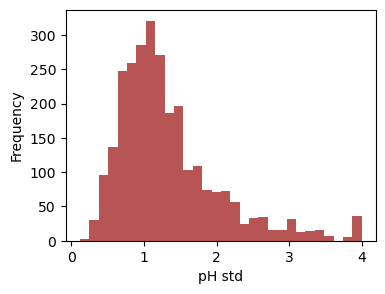

In [56]:
f, ax = plt.subplots(figsize=(4,3))
data_fits2.fit_std.plot.hist(bins=30, color="brown", alpha=0.8)
ax.set_xlabel("pH std")

<AxesSubplot: ylabel='Frequency'>

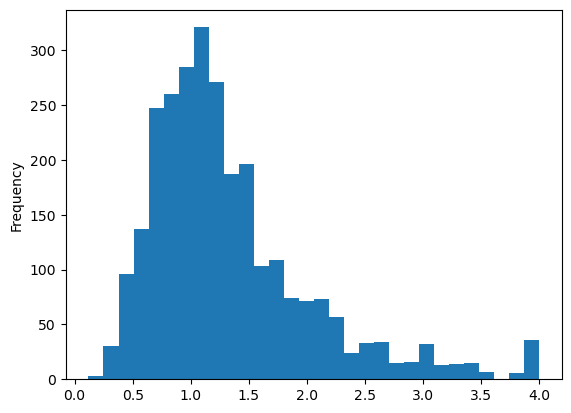

In [57]:
data_multi_fixes.fit_std.plot.hist(bins=30)

### See if there are any others to fix

In [58]:
# df_subset = data_fits2[(data_fits2.fit_std < 0.05)]# & 
#                        # (data_fits2.fit_std >= 0.5)]
# # df_subset = data_multi.copy()
# # df_subset = df_subset[df_subset.uniprot_id.isin(bad_fits)]
# print(len(df_subset))
# plot_indv_prot_curves(df_subset.iloc[0:],
#                       data_act_merged,
#                       nrows=2, ncols=4)